In [1]:
from google.colab import drive
import os
import json

drive.mount('/content/drive')

# drive.flush_and_unmount()

!ls '/content/drive/My Drive'

Mounted at /content/drive
 checkpoints  'Colab Notebooks'   Efficient+MEdbert.ipynb   GP1   GP2


In [ ]:
import zipfile

zip_file_path = '/content/drive/My Drive/GP2/images.zip'

extract_dir = '/content/drive/My Drive/GP2/original_images'
os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Images extracted successfully to {extract_dir}")

    extracted_files = os.listdir(extract_dir)
    print("Extracted files:", extracted_files)
except Exception as e:
    print(f"Error extracting zip file: {e}")

Images extracted successfully to /content/drive/My Drive/GP2/original_images
Extracted files: ['images']


# Performing Contrast Adjustment (50%) and Grid Distortion on images for the classes that require balancing
**Grid Distortion was taken from the albmentations library available at https://github.com/albumentations-team/albumentations?tab=readme-ov-file#list-of-augmentations**

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageEnhance
import cv2
import albumentations as A 
import shutil

def apply_contrast_change(image):
    """
    Adjust the contrast of the image using PIL.ImageEnhance.
    :param image: Input image (PIL Image)
    :return: Augmented image (PIL Image)
    """
    enhancer = ImageEnhance.Contrast(image)
    contrast_factor = 1.5 
    augmented_image = enhancer.enhance(contrast_factor)
    return augmented_image

def apply_grid_distortion(image):
    """
    Apply grid distortion using albumentations.
    :param image: Input image (numpy array)
    :return: Augmented image (numpy array)
    """
    aug = A.GridDistortion(num_steps=5, distort_limit=[-0.3, 0.3], p=1.0)
    augmented = aug(image=image)
    return augmented["image"]


def augment_data(record, augmentation_steps, image_folder, augmented_images_folder, augmented_json_folder):
    """
    Augment images and update JSON records.
    :param record: JSON record for the patient
    :param augmentation_steps: Number of augmentation steps (0, 1, or 2)
    :param image_folder: Folder containing original images
    :param augmented_images_folder: Folder to save augmented images
    :param augmented_json_folder: Folder to save updated JSON records
    :return: List of augmented records
    """

    u_id = record["U_id"]
    tac_images = record["TAC"]
    mri_images = record["MRI"]
    label = record["Class/Label"]

    augmented_records = []

    for tac in tac_images:
        image_path = os.path.join(image_folder, tac + ".png")  
        if os.path.exists(image_path):
            output_image_path = os.path.join(augmented_images_folder, tac + ".png")
            shutil.copy(image_path, output_image_path)
        else:
            print(f"Warning: TAC image {tac}.png not found in {image_folder}")

    for mri in mri_images:
        image_path = os.path.join(image_folder, mri + ".png") 
        if os.path.exists(image_path):
            output_image_path = os.path.join(augmented_images_folder, mri + ".png")
            shutil.copy(image_path, output_image_path)
        else:
            print(f"Warning: MRI image {mri}.png not found in {image_folder}")

    for step in range(augmentation_steps):
        augmented_record = record.copy()

        suffix = f"_bal{step + 1}"
        augmented_record["U_id"] = u_id + suffix
        augmented_record["TAC"] = [tac + suffix for tac in tac_images]
        augmented_record["MRI"] = [mri + suffix for mri in mri_images]

        for tac in tac_images:
            image_path = os.path.join(image_folder, tac + ".png")
            if os.path.exists(image_path):
                image = Image.open(image_path)  
                if step == 0:
                    augmented_image = apply_contrast_change(image) 
                elif step == 1:
                    image_np = np.array(image)  
                    augmented_image_np = apply_grid_distortion(image_np)
                    augmented_image = Image.fromarray(augmented_image_np) 
                output_image_path = os.path.join(augmented_images_folder, tac + suffix + ".png")
                augmented_image.save(output_image_path)
            else:
                print(f"Warning: TAC image {tac}.png not found in {image_folder}")

        for mri in mri_images:
            image_path = os.path.join(image_folder, mri + ".png")
            if os.path.exists(image_path):
                image = Image.open(image_path)  
                if step == 0:
                    augmented_image = apply_contrast_change(image)  
                elif step == 1:
                    image_np = np.array(image)  
                    augmented_image_np = apply_grid_distortion(image_np)  
                    augmented_image = Image.fromarray(augmented_image_np)  
                output_image_path = os.path.join(augmented_images_folder, mri + suffix + ".png")
                augmented_image.save(output_image_path)
            else:
                print(f"Warning: MRI image {mri}.png not found in {image_folder}")

        augmented_records.append(augmented_record)

    return augmented_records

def process_dataset(json_records, image_folder, output_folder):
    """
    Process the dataset and perform augmentation based on the class/label.
    :param json_records: List of JSON records for all patients
    :param image_folder: Folder containing original images
    :param output_folder: Folder to save augmented images and updated JSON records
    """
    augmentation_steps = {
        "Congenital & Genetic": 0,
        "Trauma & Physical Injuries": 1,
        "Infections": 1,
        "Vascular & Circulatory": 1,
        "Neoplasm - Benign & Sarcoma": 1,
        "Neoplasm - Carcinoma": 2,
        "Neoplasm - Other Malignant": 1,
        "Inflammatory & Autoimmune": 2,
        "Metabolic & Endocrine": 2,
        "Cysts & Degenerative Conditions": 2,
        "Obstruction & Structural Abnormalities": 2,
        "Miscellaneous Conditions": 0,
    }

    augmented_images_folder = os.path.join(output_folder, "augmented_images")
    augmented_json_folder = os.path.join(output_folder, "augmented_json")
    os.makedirs(augmented_images_folder, exist_ok=True)
    os.makedirs(augmented_json_folder, exist_ok=True)

    all_records = []

    for record in json_records:
        label = record["Class/Label"]
        steps = augmentation_steps.get(label, 0)

        all_records.append(record)

        if steps > 0:
            augmented_records = augment_data(record, steps, image_folder, augmented_images_folder, augmented_json_folder)
            all_records.extend(augmented_records)

    output_json_path = os.path.join(augmented_json_folder, "all_records.json")
    with open(output_json_path, "w") as f:
        json.dump(all_records, f, indent=4)

if __name__ == "__main__":
    with open("/content/drive/My Drive/GP2/original_dataset/Case_Topic_with_class_label.json", "r") as f:
        json_records = json.load(f)

    image_folder = "/content/drive/My Drive/GP2/original_dataset/images" 
    output_folder = "/content/drive/My Drive/GP2/Balanced_data" 

    process_dataset(json_records, image_folder, output_folder)

**Counting number of instances for each class label before and after and the total number of records**

In [ ]:
import json

def count_records_in_json(file_path):
  with open(file_path, 'r') as file:
      data = json.load(file)

  if isinstance(data, list):
      return len(data)

def count_instances_in_json(file_path):
  with open(file_path, 'r') as file:
      data = json.load(file)
  class_counts = {}

  for record in data:
      label = record["Class/Label"]
      if label in class_counts:
          class_counts[label] += 1
      else:
          class_counts[label] = 1

  for label, count in class_counts.items():
      print(f"{label}: {count}")


print("Class Label Counts before balancing:\n")
file_path = "/content/drive/My Drive/GP2/original_dataset/Case_Topic_with_class_label.json"
count_instances_in_json(file_path)
count = count_records_in_json(file_path)
print(f"\nTotal number of records: {count}")

print("\n",50*'=',"\n")

print("Class Label Counts after balancing:\n")
file_path = "/content/drive/My Drive/GP2/Balanced_data/augmented_json/all_records.json"
count_instances_in_json(file_path)
count = count_records_in_json(file_path)
print(f"\nTotal number of records: {count}")

Class Label Counts before balancing:

Miscellaneous Conditions: 172
Obstruction & Structural Abnormalities: 15
Neoplasm - Carcinoma: 36
Inflammatory & Autoimmune: 24
Neoplasm - Benign & Sarcoma: 57
Neoplasm - Other Malignant: 101
Congenital & Genetic: 88
Metabolic & Endocrine: 17
Vascular & Circulatory: 45
Infections: 41
Trauma & Physical Injuries: 59
Cysts & Degenerative Conditions: 16

Total number of records: 671


Class Label Counts after balancing:

Miscellaneous Conditions: 172
Obstruction & Structural Abnormalities: 45
Neoplasm - Carcinoma: 108
Inflammatory & Autoimmune: 72
Neoplasm - Benign & Sarcoma: 114
Neoplasm - Other Malignant: 202
Congenital & Genetic: 88
Metabolic & Endocrine: 51
Vascular & Circulatory: 90
Infections: 82
Trauma & Physical Injuries: 118
Cysts & Degenerative Conditions: 48

Total number of records: 1190


##**Testing different augmentation techniques**

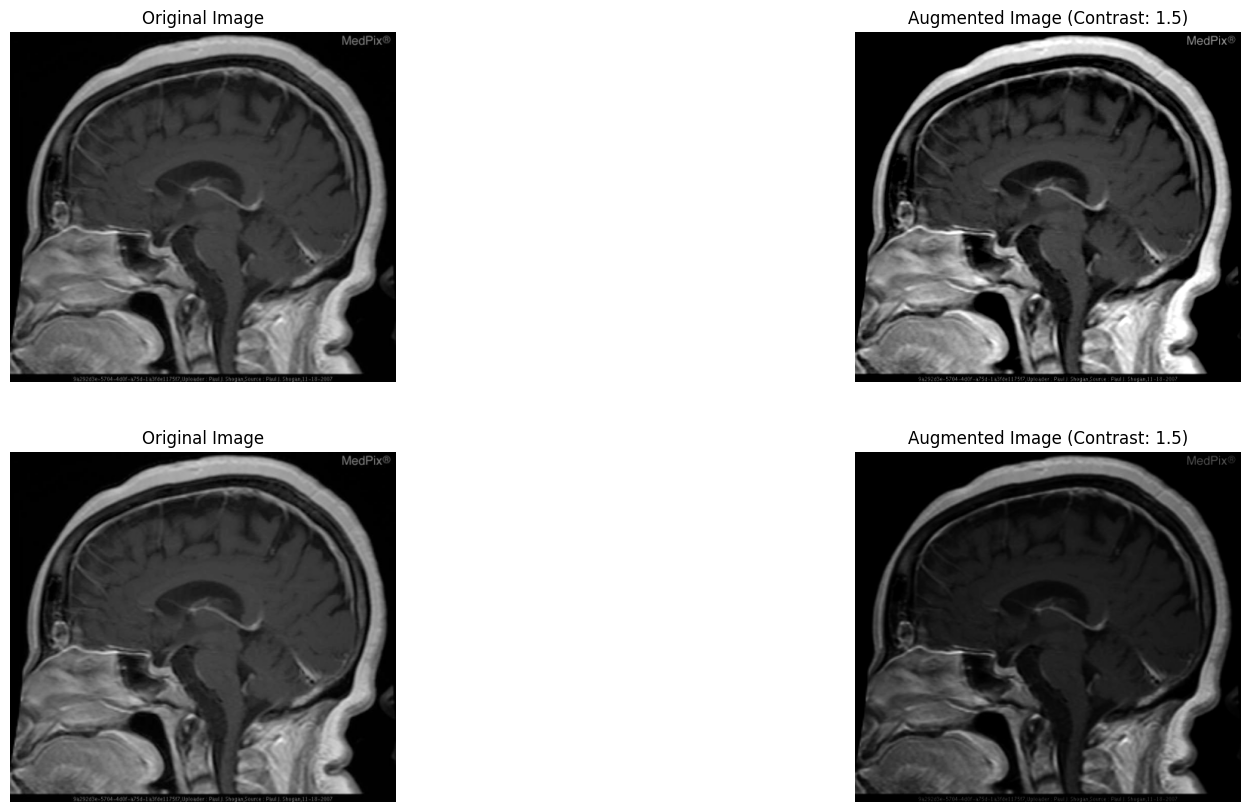

In [ ]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np

# ************Contrast************
image_path = '/content/im1.png'
image = Image.open(image_path)

enhancer = ImageEnhance.Contrast(image)

contrast_factor = 1.5

augmented_image = enhancer.enhance(contrast_factor)

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(augmented_image)
plt.title(f'Augmented Image (Contrast: {contrast_factor})')
plt.axis('off')


# ************Gamma Correction************
image_path = '/content/im1.png'
image = Image.open(image_path)

image_array = np.array(image)

def gamma_correction(image, gamma=1.0):
    image_normalized = image / 255.0
    gamma_corrected = np.power(image_normalized, gamma)
    gamma_corrected = np.uint8(gamma_corrected * 255)
    return gamma_corrected

gamma_value = 1.5
augmented_image_array = gamma_correction(image_array, gamma=gamma_value)

augmented_image = Image.fromarray(augmented_image_array)

plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(augmented_image)
plt.title(f'Augmented Image (Contrast: {contrast_factor})')
plt.axis('off')

plt.show()

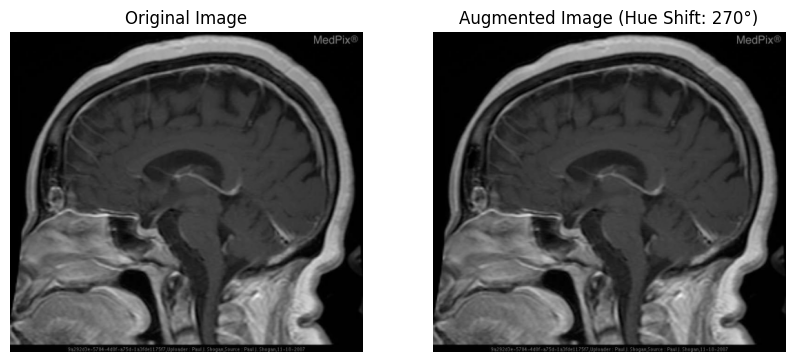

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# ************Hue adjustment************
image_path = '/content/im1.png'  
image = Image.open(image_path)

hsv_image = image.convert('HSV')

h, s, v = hsv_image.split()

hue_shift = 270  
h = h.point(lambda x: (x + hue_shift) % 256)

adjusted_hsv_image = Image.merge('HSV', (h, s, v))

augmented_image = adjusted_hsv_image.convert('RGB')

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title(f'Augmented Image (Hue Shift: {hue_shift}°)')
plt.axis('off')

plt.show()

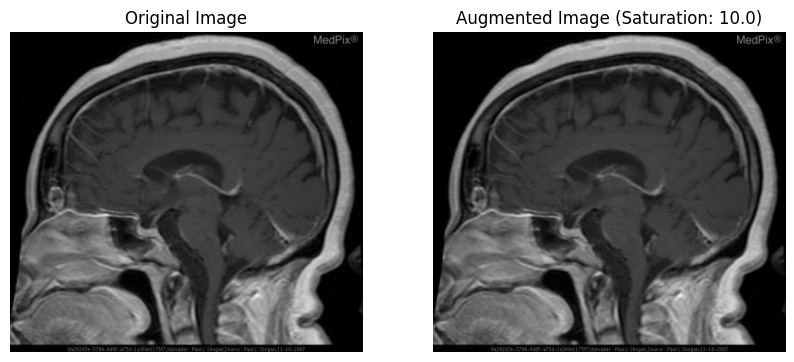

In [ ]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# ************Saturation************
image_path = '/content/im1.png' 
image = Image.open(image_path)

enhancer = ImageEnhance.Color(image)

saturation_factor = 10.0
augmented_image = enhancer.enhance(saturation_factor)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title(f'Augmented Image (Saturation: {saturation_factor})')
plt.axis('off')

plt.show()

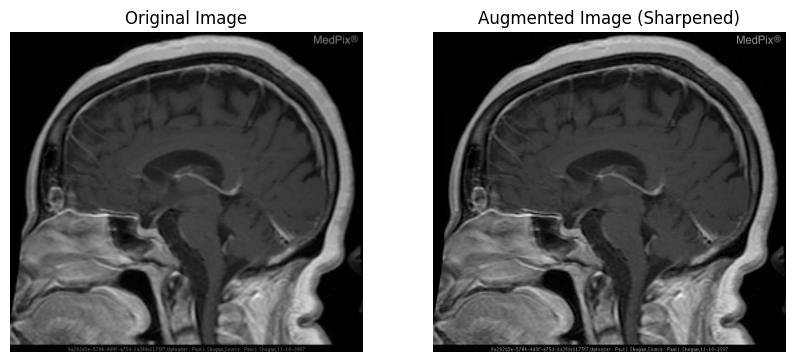

In [ ]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# ************Sharpening************
image_path = '/content/im1.png'
image = Image.open(image_path)

augmented_image = image.filter(ImageFilter.SHARPEN)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image (Sharpened)')
plt.axis('off')

plt.show()